# project9 : 폐렴 진단기


- CNN 기반 딥러닝 모델 구현
- ablation study(regularization, augmentation 등의 기법의 사용 여부)
- 폐렴 검출 정확도(Accuracy)

-------

## Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 하이퍼마
BATCH_SIZE = 32
EPOCHS = 40 #earlystop걸기!

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
#데이터 가져오기

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):    #train_ds.take(1)은 하나의 데이터만 가져온다는 의미
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


-----

## Step 2. 데이터 준비하기

- Augmentation : Random Resize / crop
- Regularization : BatchNorm / Dropout

In [14]:
input_shape = [180, 180, 3]

def augment(image,label):
    # random resize and random crop back to expected size
    random_scale_factor = tf.random.uniform([1], minval=1., maxval=1.4, dtype=tf.float32)
    scaled_height = tf.cast(tf.cast(input_shape[0], tf.float32) * random_scale_factor, tf.int32)
    scaled_width = tf.cast(tf.cast(input_shape[1], tf.float32) * random_scale_factor, tf.int32)       
    scaled_shape = tf.squeeze(tf.stack([scaled_height, scaled_width]))

    image = tf.image.resize(image, scaled_shape)
    image = tf.image.random_crop(image, input_shape)
    
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가됨
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

-----

## Step 3. 데이터 시각화

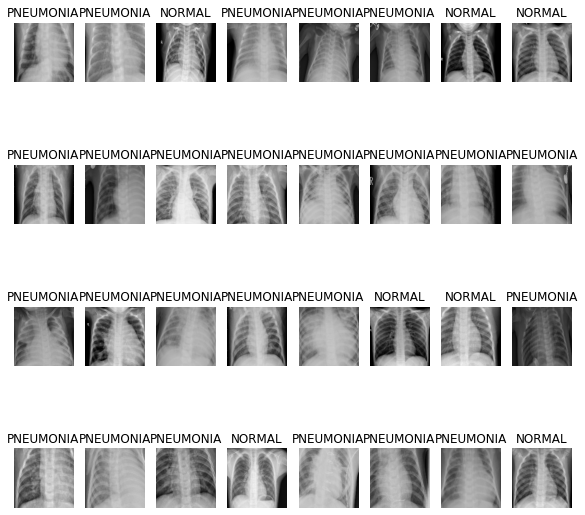

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

In [16]:
#CNN모델링

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

----

## Step 5. 데이터 imbalance 처리

In [19]:
# 데이터 imbalance 처리

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.5),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [20]:
#데이터 imbalance 처리

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam', #nadam 등으로 바꿀 수 있다.
        loss='binary_crossentropy',
        metrics=METRICS
    )

-----

## Step 6. 모델 훈련

In [22]:
#모델 훈련
#loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려하라!

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
130/130 [==============================] - 63s 382ms/step - loss: 0.5711 - accuracy: 0.6906 - precision: 0.9070 - recall: 0.6515 - val_loss: 0.5850 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/40
130/130 [==============================] - 50s 387ms/step - loss: 0.3628 - accuracy: 0.8377 - precision: 0.9575 - recall: 0.8176 - val_loss: 0.5880 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/40
130/130 [==============================] - 51s 395ms/step - loss: 0.3033 - accuracy: 0.8736 - precision: 0.9629 - recall: 0.8635 - val_loss: 0.6142 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 4/40
130/130 [==============================] - 52s 404ms/step - loss: 0.2727 - accuracy: 0.8813 - precision: 0.9647 - recall: 0.8726 - val_loss: 1.0166 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 5/40
130/130 [==============================] - 55s 426ms/step - loss: 0.2505 - accura

Epoch 37/40
130/130 [==============================] - 48s 368ms/step - loss: 0.1170 - accuracy: 0.9606 - precision: 0.9871 - recall: 0.9597 - val_loss: 0.1237 - val_accuracy: 0.9473 - val_precision: 0.9972 - val_recall: 0.9311
Epoch 38/40
130/130 [==============================] - 47s 366ms/step - loss: 0.1202 - accuracy: 0.9510 - precision: 0.9866 - recall: 0.9471 - val_loss: 0.2115 - val_accuracy: 0.9268 - val_precision: 1.0000 - val_recall: 0.9001
Epoch 39/40
130/130 [==============================] - 47s 359ms/step - loss: 0.1237 - accuracy: 0.9555 - precision: 0.9863 - recall: 0.9533 - val_loss: 0.0973 - val_accuracy: 0.9531 - val_precision: 0.9526 - val_recall: 0.9854
Epoch 40/40
130/130 [==============================] - 52s 399ms/step - loss: 0.1179 - accuracy: 0.9565 - precision: 0.9854 - recall: 0.9558 - val_loss: 0.0754 - val_accuracy: 0.9668 - val_precision: 0.9851 - val_recall: 0.9693


----

## Step 7. 결과 확인과 시각화

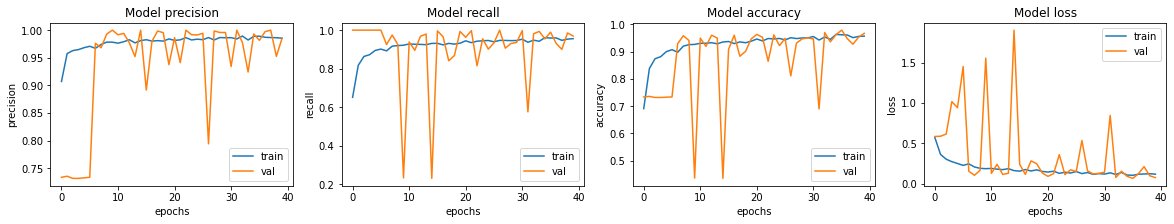

In [23]:
#결과 확인

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 260ms/step - loss: 0.3450 - accuracy: 0.9006 - precision: 0.8727 - recall: 0.9846
Loss: 0.34504011273384094,
Accuracy: 0.9006410241127014,
Precision: 0.8727272748947144,
Recall: 0.9846153855323792


--------

# 회고

    "헬스케어에 관심 있던 나에게 딱 맞는 주제!"

금융사를 준비해왔던 저는 보험 부문도 공부했었는데, 보험사들이 신사업으로 헬스케어에 관심이 많다는 것을 알고 있습니다. 그 이유는 새로운 수익원을 창출하고 싶은 것도 있지만, 제가 생각하는 보험사들의 궁극적인 이유는 헬스케어를 통한 보험금을 줄이기 위해서인 것같습니다. 이처럼 저와도 밀접하고 궁금했던 부분을 배울 수 있었습니다.

이번 프로젝트에서는 인공지능 딥러닝으로써 폐렴 진단의 방법을 배울 수 있었습니다. 저는 좌우반전, 색밝기 조정, 사이즈 크롭 등의 몇가지 방법으로 데이터를 변형하여 학습을 시도했습니다. 여러가지 요인 덕분에 accuracy나 recall을 높일 수 있었습니다.

결과적으로, epoch = 40이나? 주었기에 loss: 0.3450 - accuracy: 0.9006 - precision: 0.8727 - recall: 0.9846 라는 목표보다 높은 성능을 보였고 그래프를 통해 과적합도 어느 정도 잘 잡았습니다.

처음에는 막연히 학습량만 증가시키면 무조건 accuracy도 높아질거라 생각했는데, 어떻게 데이터를 처리해주느냐에 따라 모델 성능이 좋아지기도 하고 나빠지기도 할 수 있다는 것을 몸소 확인할 수 있었습니다. 또한 augmentation을 가지고 cnn 모델을 변경시키기도 했습니다.

의사들의 정확도도 90%내외인 것을 보면 의료데이터를 보편화시켜 ai와 의사들이 합심해 조금 더 많은 생명을 지키는 사회가 되었으면 좋겠습니다. 또한, 헬스케어라는 사업 중 진료 및 의료가 지금보다 더 신뢰할 만한 사업이 될 수 있도록 DL 모델을 더욱 적합하게 짤 수 있는 AI전문가가 되겠습니다.